# PHASE DIAGRAM 

## Reseau definition

In [1]:
#Imports needed
import numpy as np #For everything                              version 
import matplotlib.pyplot as plt #For visualisation              version 
import networkx as nx #For the graph                            version 
from pickle import load as pload #For loading the gpickle file  version 
from PIL import Image #For image management                     version 
from tqdm import tqdm #For nice loading bars                    version 
from declaration_tutti import load, treat_a_new_reseau, load_from_scratch
from fct_utils import prune,xy2t
from fct_analyse import arbre_genealogique_branches,color_by_time
#Our part:
from Reseau import Reseau,Brindille,Branche 
from scipy.optimize import curve_fit
from IPython.display import Image

In [2]:
reseau= load('M2WT_200616',"branched")
for b in reseau.branches:
        b.n2x = reseau.n2x
        b.n2y = reseau.n2y
        b.n2t = reseau.n2t

In [3]:
def abscisse_curviligne(branch)->np.ndarray:
    """
    Renvoie la liste des abscisses curvilignes des noeuds de la branche
    """
    pos = np.array([[branch.n2x[n],branch.n2y[n]] for n in branch.noeuds])
    abscisse = np.sqrt(np.sum((pos[1:,:]-pos[:-1,:])**2,axis=-1))
    abscisse = np.cumsum(abscisse)
    abscisse = np.insert(abscisse,0,0)
    return abscisse

In [4]:
def distance(nodo1 , nodo2, branch):
    list_ascisse = abscisse_curviligne(branch)
    nodo_1 = branch.noeuds.index(nodo1)
    nodo_2= branch.noeuds.index(nodo2)
    distance = list_ascisse[nodo_2] - list_ascisse[nodo_1]
    return distance

In [5]:
k=0
for i in reseau.branches:
    if i.ending == 'Fusion?':
        k+=1
print(k)

1154


# THEORY 

There is a latence time for the development of lateral branches that separates the growth of the two different kinds of branhces $\Delta \tau_{AL}$. So before that trashold only lateral branches can occour?? . So, assuming uniform velocity of the growing branch, we assume that MIBs can only occour in a certain region of the phase diagram delimited by the law: 

$$ L_{MIB} \, (iT) = V_{AP / LAT} \cdot (\Delta \tau_{AL} - iT)$$

In this notebook we are trying to isolate the points that belong to the $L_{MIB}$  region. 

## Algorithm to calculate appearing branches after fusion 

#### let's re-define the nature of the branches according to their latency time: 

In [6]:
tau = 5 
for b in reseau.branches:
    starting_node = b.noeuds[0]
    
    starting_time = reseau.n2t[starting_node]
    DELTA = b.get_tstart() - starting_time
    if  DELTA  <= tau and DELTA > 0:
        
        b.nature = 'Apical'
    else: b.nature = 'Lateral' 

### First let's take the lateral sons 

In [7]:
no_overlaps = [n for b in reseau.branches for n in b.noeuds if n > 0]
lateralBranching = [b.noeuds[0]  #tutti i nodi di inizio di branch laterali.
                       for b in reseau.branches 
                       if b.nature == "Lateral"]

In [8]:
# Initialize dictionaries to store distances and time differences for each 'b'
distances_dict_lat = {}
time_diffs_dict_lat = {}
distances_lat=[]
times_lat=[]
marker_lateral_son=[]

for b in reseau.branches:
    if b.ending == 'Fusion?':         
       
        vicini_out = reseau.neighborhood()[b.index]['out']  
        nodi_fuso = b.noeuds 
        t_fusione = b.get_tend()  
        nodo_fusione = b.noeuds[-1]  
        distances_dict_lat[b] = {}  
        time_diffs_dict_lat[b] = {} 
        
        for j in vicini_out:  
            starting_node = j.noeuds[0] 
            
            if starting_node in no_overlaps:
                if starting_node in lateralBranching:
                    if starting_node != nodo_fusione:  # If the starting node of the neighbor is the father of a lateral branch and is a node of no overlap 
                        # Calculate starting time as the time of the second element of the branchement  
                        starting_time = j.get_tstart()  
                        
                        if t_fusione  < starting_time:
                            if j != b: 
                                dis = distance(  starting_node,nodo_fusione, b)  
                                time_diff = starting_time - t_fusione
                                distances_lat.append(dis)
                                if b.nature == 'Apical':
                                    marker_lateral_son.append('s')
                                if b.nature == 'Lateral':
                                    marker_lateral_son.append('o')
                                times_lat.append(time_diff)
                                distances_dict_lat[b][j] = dis
                                time_diffs_dict_lat[b][j] = time_diff


### Now add also apical sons in a different dictionary

In [9]:
apicalBranching = [b.noeuds[0]  #tutti i nodi di inizio di branch apicali.
                       for b in reseau.branches 
                       if b.nature == "Apical"]

In [10]:
# Initialize dictionaries to store distances and time differences for each 'b'
distances_dict_ap = {}
time_diffs_dict_ap = {}
distances_ap=[]
times_ap=[]
marker_apical_son=[]
apical_son_apical_mother=[]
apical_son_lateral_mother=[]
for b in reseau.branches:
    if b.ending == 'Fusion?':         
       
        vicini_out = reseau.neighborhood()[b.index]['out']  
        nodi_fuso = b.noeuds 
        t_fusione = b.get_tend()  
        nodo_fusione = b.noeuds[-1]  
        distances_dict_ap[b] = {}  
        time_diffs_dict_ap[b] = {} 
        
        for j in vicini_out:  
            starting_node = j.noeuds[0] 
            
            if starting_node in no_overlaps:
                if starting_node in apicalBranching:
                    if starting_node != nodo_fusione:  # If the starting node of the neighbor is the father of a lateral branch and is a node of no overlap 
                        # Calculate starting time as the time of the second element of the branchement  
                        starting_time = j.get_tstart()  
                        
                        if t_fusione <= starting_time: #<= t_fusione + 1:
                            if j != b: 
                                dis = distance(  starting_node,nodo_fusione, b)  
                                time_diff = starting_time - t_fusione
                                distances_ap.append(dis)
                                times_ap.append(time_diff)
                                if b.nature == 'Apical':
                                    marker_apical_son.append('s')
                                    apical_son_apical_mother.append(dis)
                                if b.nature == 'Lateral':
                                    marker_apical_son.append('o')
                                    apical_son_lateral_mother.append(dis)
                    
                            
                                distances_dict_ap[b][j] = dis
                                time_diffs_dict_ap[b][j] = time_diff


In [11]:
times = np.concatenate([times_ap, times_lat])
distances = np.concatenate([distances_ap, distances_lat])
markers = np.concatenate([marker_apical_son, marker_lateral_son])
# Assign colors for points from different datasets

## PHASE DIAGRAM

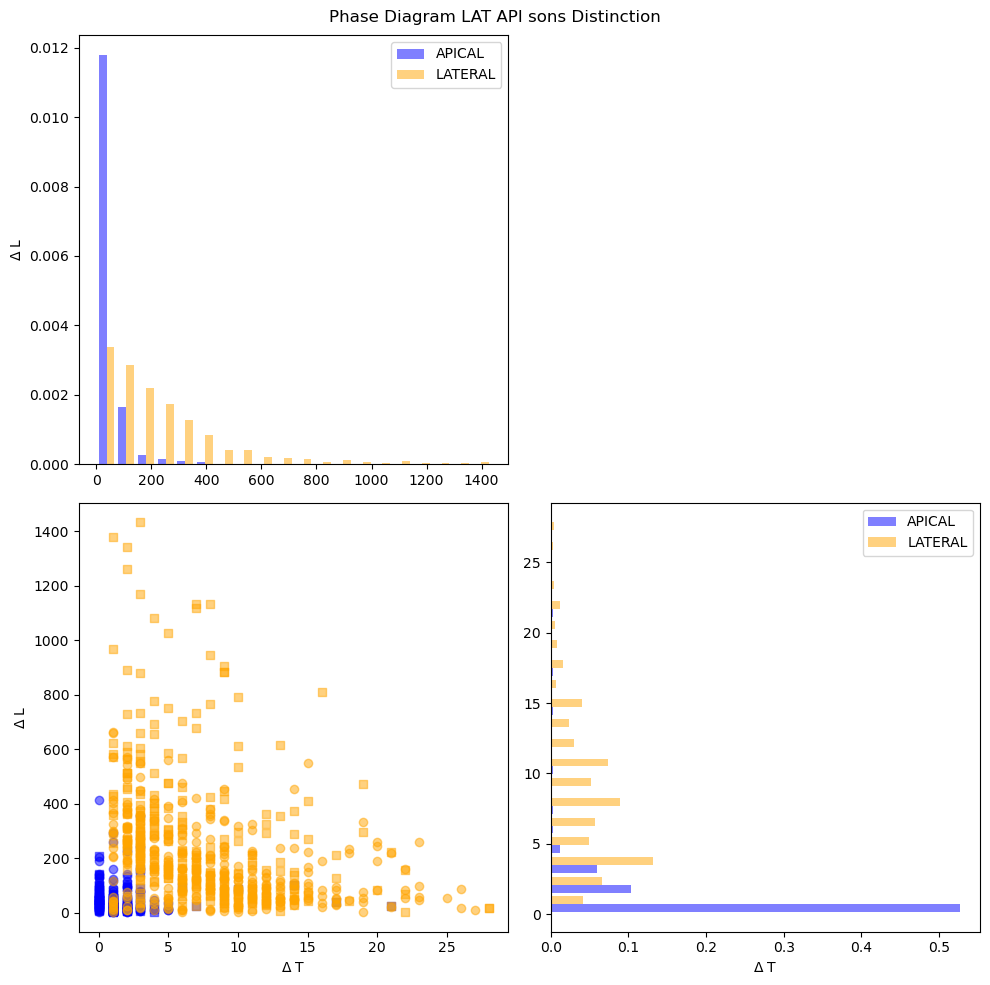

In [12]:
colors = np.array(['blue'] * len(times_ap) + ['orange'] * len(times_lat))

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot histograms
axs[0, 0].hist([distances_ap, distances_lat], bins=20,density =True, alpha=0.5, color=['blue', 'orange'], orientation='vertical', label=['APICAL', 'LATERAL'])
axs[0, 0].set_ylabel('$\Delta$ L')
axs[0, 0].legend()

axs[1, 1].hist([times_ap,times_lat], bins=20, density =True, alpha=0.5, color=['blue', 'orange'], orientation='horizontal', label=['APICAL', 'LATERAL'])
axs[1, 1].set_xlabel('$\Delta$ T')
axs[1, 1].legend()

# Plot scatter plot
for i in range(len(times)):
    axs[1, 0].scatter(times[i], distances[i], color=colors[i], marker=markers[i], alpha=0.5)
axs[1, 0].set_xlabel('$\Delta$ T')
axs[1, 0].set_ylabel('$\Delta$ L')

# Remove empty subplot
plt.delaxes(axs[0, 1])

# Add title
plt.suptitle('Phase Diagram LAT API sons Distinction')

# Adjust layout
plt.tight_layout()
# Show plot
plt.show()

### DEFINE QUANTITIES OF INTREST 

* $V_{ap} \approx  4 \mu m /= 45 \, pixel/frame$
* $V_{lat} \approx 1/2 \, V_{ap} = 32.625 \, pixel/frame $
* $\Delta \tau_{AL} = 90 \,  min = 5 \, frames$.

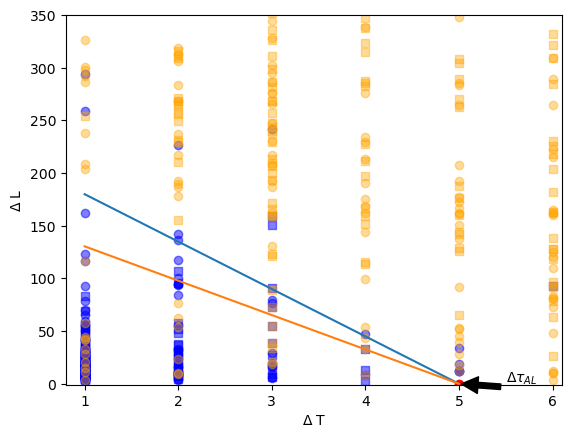

In [13]:
v_ap = 45
v_lat = 32.625
tau = 5 
x_values = np.arange(1 , 6 , 1) 
y_values_ap = - ((x_values - tau) * v_ap) 
y_values_lat= - (x_values - tau) * v_lat
for i in range(len(times_ap)):
    plt.scatter(times_ap[i], distances_ap[i], color= 'blue', marker = markers[i], alpha=0.5, label= 'Apical')
for j in range(len(times_lat)):
    q = len(times_ap) + j
    plt.scatter(times_lat[j] , distances_lat[j] , color= 'orange' , marker = markers[q],  alpha= 0.4, label = 'Lateral')

plt.plot(x_values , y_values_ap , label = 'Apical')
plt.plot(x_values , y_values_lat , label = 'Lateral')
plt.scatter(tau , 0, color='red', label= r'$\Delta \tau _{AL}$')

plt.annotate(r'$\Delta \tau _{AL}$', xy=(tau, 0), xytext=(tau +0.5 , 0 + 1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlim(0.8, 6.1 )
plt.ylim(-0.9, 350)
plt.xlabel('$\Delta$ T')
plt.ylabel('$\Delta$ L')
plt.show()

## $$ L_{MIB} \, (iT) = V_{AP / LAT} \cdot (\Delta \tau_{AL} - iT)$$

# FOR FIRST OCCURENCIES ONLY

In [14]:
closest_neighbors_old_lat = {}
for b in distances_dict_lat.keys():
    min_distance = float('inf') 
    closest_neighbor = None
    for neighbor, distance in distances_dict_lat[b].items():
        if distance < min_distance:
            min_distance = distance
            closest_neighbor = neighbor
    closest_neighbors_old_lat[b] = (closest_neighbor, min_distance)

closest_neighbors_new_lat = closest_neighbors_old_lat.copy()
for i in closest_neighbors_old_lat.keys():

    if closest_neighbors_old_lat[i] == (None, float('inf')) : 
        closest_neighbors_new_lat.pop(i)



closest_neighbors_lat = {key: value[1] for key, value in closest_neighbors_new_lat.items()}


closest_times_old_lat = {}

for b in time_diffs_dict_lat.keys():
    min_time_diff = float('inf') 
    closest_time = None 
    for neighbor, time_diff in time_diffs_dict_lat[b].items():
        if time_diff < min_time_diff:
            min_time_diff = time_diff
            closest_time = time_diff  # Assigning closest_time to the time difference
    
    if closest_time != None:
        closest_times_old_lat[b] = closest_time 
closest_times_new_lat = closest_times_old_lat.copy()

for i in closest_times_old_lat.keys():
    if closest_times_old_lat[i] == None : 
        closest_times_new_lat.pop(i)
closest_times_lat = {key: value for key, value in closest_times_new_lat.items()}

In [15]:
closest_neighbors_old_ap = {}
for b in distances_dict_ap.keys():
    min_distance = float('inf') 
    closest_neighbor = None
    for neighbor, distance in distances_dict_ap[b].items():
        if distance < min_distance:
            min_distance = distance
            closest_neighbor = neighbor
    closest_neighbors_old_ap[b] = (closest_neighbor, min_distance)

closest_neighbors_new_ap = closest_neighbors_old_ap.copy()
for i in closest_neighbors_old_ap.keys():

    if closest_neighbors_old_ap[i] == (None, float('inf')) : 
        closest_neighbors_new_ap.pop(i)



closest_neighbors_ap = {key: value[1] for key, value in closest_neighbors_new_ap.items()}



closest_times_old_ap = {}

for b in time_diffs_dict_ap.keys():
    min_time_diff = float('inf') 
    closest_time = None 
    for neighbor, time_diff in time_diffs_dict_ap[b].items():
        if time_diff < min_time_diff:
            min_time_diff = time_diff
            closest_time = time_diff  # Assigning closest_time to the time difference
    
    if closest_time != None:
        closest_times_old_ap[b] = closest_time 
        
closest_times_new_ap = closest_times_old_ap.copy()

for i in closest_times_old_ap.keys():
    if closest_times_old_ap[i] == None : 
        closest_times_new_ap.pop(i)
closest_times_ap = {key: value for key, value in closest_times_new_ap.items()}

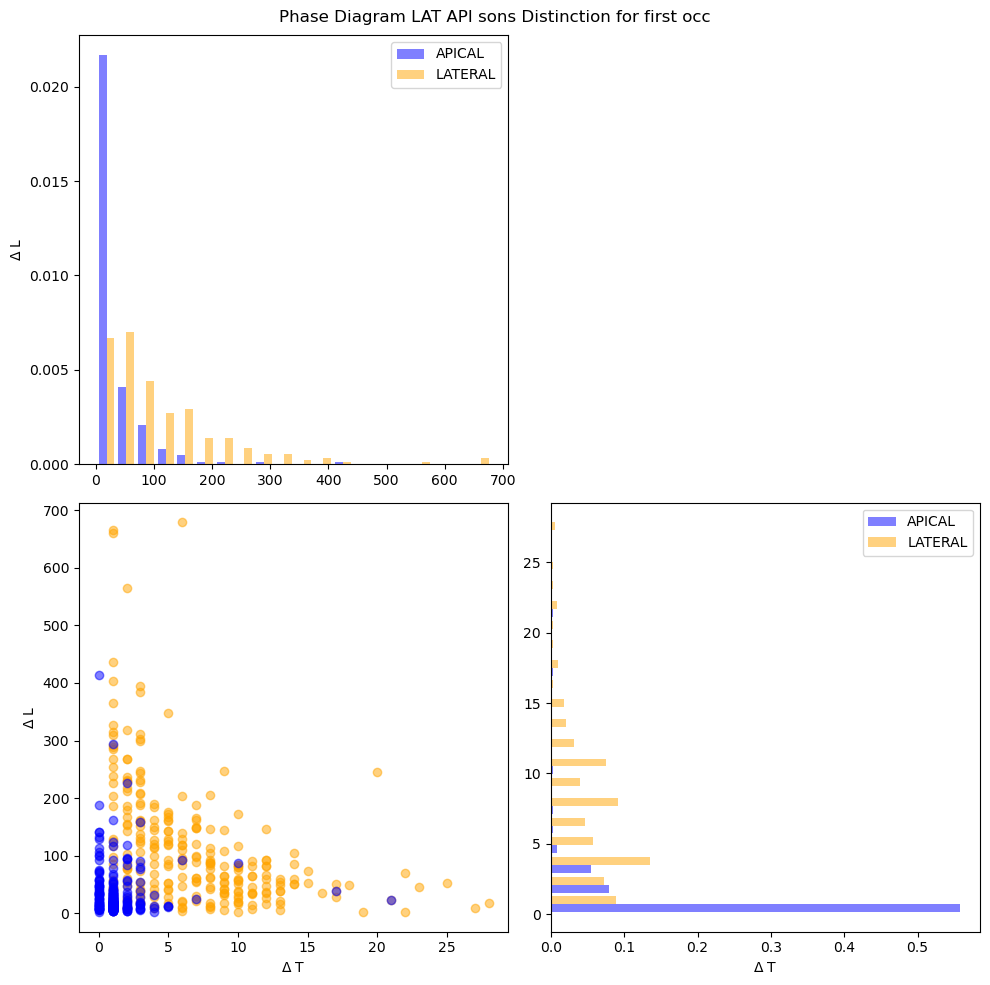

In [16]:

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot histograms
axs[0, 0].hist([list(closest_neighbors_ap.values()), list(closest_neighbors_lat.values())], bins=20,density =True, alpha=0.5, color=['blue', 'orange'], orientation='vertical', label=['APICAL', 'LATERAL'])
axs[0, 0].set_ylabel('$\Delta$ L')
axs[0, 0].legend()

axs[1, 1].hist([list(closest_times_ap.values()) , list( closest_times_lat.values())], bins=20, density =True, alpha=0.5, color=['blue', 'orange'], orientation='horizontal', label=['APICAL', 'LATERAL'])
axs[1, 1].set_xlabel('$\Delta$ T')
axs[1, 1].legend()

# Plot scatter plot
axs[1, 0].scatter(list(closest_times_lat.values()), list(closest_neighbors_lat.values()), color='orange', alpha=0.5)
axs[1, 0].scatter(list(closest_times_ap.values()),list( closest_neighbors_ap.values()), color='blue', alpha=0.5)
axs[1, 0].set_xlabel('$\Delta$ T')
axs[1, 0].set_ylabel('$\Delta$ L')

# Remove empty subplot
plt.delaxes(axs[0, 1])

# Add title
plt.suptitle('Phase Diagram LAT API sons Distinction for first occ')

# Adjust layout
plt.tight_layout()
# Show plot
plt.show()

In [17]:
times_first = np.concatenate([list(closest_times_ap.values()),list(closest_times_lat.values())])
distances_first = np.concatenate([list(closest_neighbors_ap.values()), list(closest_neighbors_lat.values())])


times_MIB_first=[]
distances_MIB_first=[]                                   #li cerco tra tutti o solo tra i lateral? 
for time in times_first:
    for dist in distances_first: 
        L_MIB = v_lat * (tau - time)
        if dist <= L_MIB: 
            times_MIB_first.append(time)
            distances_MIB_first.append(dist)

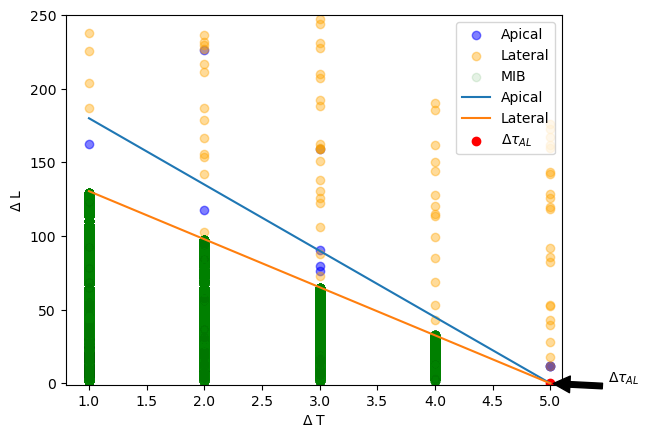

In [18]:
x_values = np.arange(1 , 6 , 1) 
y_values_ap = - ((x_values - tau) * v_ap) 
y_values_lat= - (x_values - tau) * v_lat
plt.scatter(list(closest_times_ap.values()), list(closest_neighbors_ap.values()), color= 'blue', alpha=0.5, label= 'Apical')
plt.scatter(list(closest_times_lat.values()) , list(closest_neighbors_lat.values()) , color= 'orange' , alpha= 0.4, label = 'Lateral')
plt.scatter(times_MIB_first , distances_MIB_first , color = 'green' ,alpha = 0.1  , label = 'MIB')
plt.plot(x_values , y_values_ap , label = 'Apical')
plt.plot(x_values , y_values_lat , label = 'Lateral')
plt.scatter(tau , 0, color='red', label= r'$\Delta \tau _{AL}$')

plt.annotate(r'$\Delta \tau _{AL}$', xy=(tau, 0), xytext=(tau +0.5 , 0 + 1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlim(0.8, 5.1 )
plt.ylim(-0.9, 250)
plt.xlabel('$\Delta$ T')
plt.ylabel('$\Delta$ L')
plt.legend(loc='upper right')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

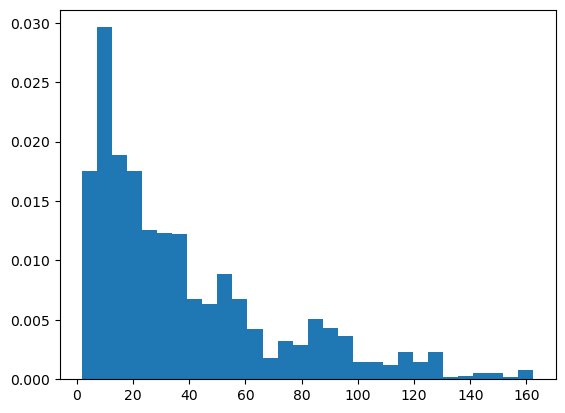

In [19]:
plt.hist(distances_MIB_first, bins = 30 , density = True)
plt.show

## QUESTIONS


* Doing like I did of putting b.nature = 'Apical' $\iff$ b.get_tstart() .. etc. forces the $\Delta Ts$ to stay within $0 \leq \Delta T < \Delta \tau_{AL} $ , and compared to when we chose the nature of the branch directly from b.nature, we have way more apical branchings  with actually higher $\Delta T$  **$\rightarrow$**  between the two choices it doesn't change a lot, there are slightly more Apicals and  some of them have higher $\Delta T$ but the distributions don't change substancially.     USA DEFINIZIONE DI THIBAULT 
* When I LOOK FOR MIBs should I only consider apical branches too in the line interval? **$\rightarrow$** now it's plotted with apicals and laterals). CONSIDER BOTH 
* Should I consider only first occurrences?  **$\rightarrow$** I don't think the distributions change substancially and the peak have more or less the same order of magnitude. 
* Should I normalize by the length of the branches? SI 
* Should I normalize the phase diagram by the TOTAL number of apical and lateral too? Because it is normalized like apical / number of apical occurrences but the apical occurrences are different than the lateral ones 